# A moving ball - A Multimesh Motivation


This notebook contains an comparasion of a single-mesh and multimesh approach for a ball moving with a constant speed in a channel.
We start by importing the packages needed.

In [1]:
from dolfin import *
import matplotlib.pyplot as plt

We then create a single mesh, describing an obstacle in a channel, with *pygmsh* and *gmsh*, and convert it to a dolfin readable format using *meshio*. We use the functions located in **motivation_meshes.py
** to create the meshes.

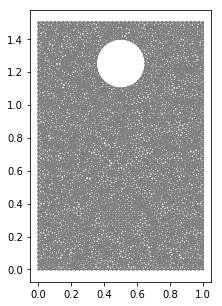

In [2]:
%load_ext autoreload
from motivation_meshes import single_mesh, background_mesh, front_mesh, outer_marker, inner_marker, mesh_folder
mesh_resolution = 0.025
single_mesh(mesh_resolution)
mesh = Mesh()
with XDMFFile(mesh_folder+"singlemesh.xdmf") as infile:
    infile.read(mesh)
mvc = MeshValueCollection("size_t", mesh, 1)
with XDMFFile(mesh_folder+"mf_singlemesh.xdmf") as infile:
    infile.read(mvc, "name_to_read")
mf = cpp.mesh.MeshFunctionSizet(mesh, mvc)

%matplotlib inline
plt.figure(figsize=(5,5))
plot(mesh)
plt.show()

Thereafter, we create a function describing the velocity field of the ball. To only create a vector field that
is non-zero on the ball, we use a *DirichletBc*.

In [3]:
V = VectorFunctionSpace(mesh, "CG", 1)
velocity = Function(V)
bc_v = DirichletBC(V, Constant((0,-0.1)), mf, inner_marker)
bc_v.apply(velocity.vector())

When the ball starts falling, we need to update the mesh. We use a smoothed $H^1(\Omega)$-representation of the function that is $(0,-0.02)$ on the ball and $(0,0)$ on the outer boundaries.

In [4]:
u, v = TrialFunction(V), TestFunction(V)
# Smoothed H1 representation as variational form
a = 0.1*inner(grad(u), grad(v))*dx + inner(u,v)*dx
l = inner(Constant((0,0)),v)*dx
displacement = Function(V)

We define a function for the falling ball until time `t=T_end` as

In [12]:
%matplotlib inline
import time

def falling_ball(T_end, dt):
    plt.subplot(1,2,1)
    # Set boundary conditions for velocity field
    b_outer = DirichletBC(V, Constant((0,0)), mf, outer_marker)
    bc_displacement = DirichletBC(V, Constant(dt)*velocity, mf, inner_marker)
    bcs = [b_outer, bc_displacement]
    org_position=mesh.coordinates().copy()
    # Compute displacement field at time T_end
    t_0 = 0
    start = time.time()
    while t_0<=T_end:
        A, L = assemble(a), assemble(l)
        [bc.apply(A, L) for bc in bcs]
        solve(A, displacement.vector(), L)
        # Move mesh
        ALE.move(mesh, displacement)
        t_0+=dt
    end = time.time()

    plot(mesh, color="r")
    plt.title("Runtime FEM: {0:.2e} seconds"
              .format(end-start))
    mesh.coordinates()[:]=org_position
    return end-start

We now introduce the notion of multiple meshes, which we use to make an alternative representation of the ball.
We import two different meshes from *motivation_meshes.py*


In [6]:
front_mesh(mesh_resolution)
background_mesh(mesh_resolution)
mesh_files = [mesh_folder+"background_mesh.xdmf", mesh_folder+"front_mesh.xdmf"]
mf_files = [mesh_folder+"mf_background.xdmf", mesh_folder+"mf_front.xdmf"]
# We create the MultiMesh object containing both meshes
multimesh = MultiMesh()
mfs = []
for i in range(2):
    mesh_i = Mesh()
    with XDMFFile(mesh_files[i]) as infile:
        infile.read(mesh_i)
        multimesh.add(mesh_i)
    mvc = MeshValueCollection("size_t", mesh_i, 1)
    with XDMFFile(mf_files[i]) as infile:
        infile.read(mvc, "name_to_read")
    mfs.append(cpp.mesh.MeshFunctionSizet(mesh_i, mvc))

We now visualize the meshes in the `MultiMesh`-object

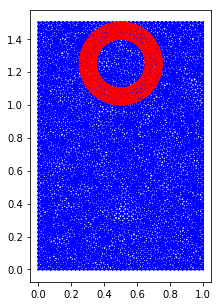

In [7]:
%matplotlib inline
colors = ["b", "r"]
fig = plt.figure(figsize=(5,5))
for i in range(multimesh.num_parts()):
    plot(multimesh.part(i), zorder=i, color=colors[i])
plt.show()

We compute the intersections between the meshes, mark the cells inside the object and deactivate them with the following commands

In [8]:
multimesh.build()
center_of_ball = Point(0.5,1.2)
multimesh.auto_cover(0, center_of_ball)

We create a similar function for the falling ball with MultiMeshes.

In [9]:
from ipywidgets import interact_manual
import ipywidgets as widgets
from motivation_meshes import ball_height
def falling_ball_multimesh(T_end, dt):
    start = time.time()
    org_position=multimesh.part(1).coordinates().copy()
    t_0 = 0
    # Compute displacement field per timestep
    displacement = Point(0, -0.1*dt)
    while t_0<=T_end:
        # Move the top mesh
        multimesh.part(1).translate(displacement)
        # Deactivate cells inside ball
        multimesh.auto_cover(0,Point(0, ball_height-displacement[1]))
        # Recompute intersections
        multimesh.build()
        t_0+=dt
    end = time.time()
    plt.subplot(1,2,2)
    plot(multimesh.part(0), zorder=0)
    plot(multimesh.part(1), color="r")
    plt.title("Runtime {0:.2e} seconds".format(end-start))
    multimesh.part(1).coordinates()[:]=org_position
    return end-start

We disable scrolling in output for the comparasion function

In [10]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Finally, we create a comparasion function that compares the two methods and their runtime

In [11]:
def compare_methods(T_end, dt):
    fig = plt.figure(figsize=(15,15))
    print("Simulation of falling ball to T={0:.1f} with {1:1d} timesteps".format(T_end, int(T_end/dt)))
    print("Running simulation...")
    t_FEM = falling_ball(T_end, dt)
    t_MMFEM = falling_ball_multimesh(T_end, dt)
    print("Runtime-ratio FEM/MMFEM: {0:.2f}".format(t_FEM/t_MMFEM))
    plt.show()
import IPython
interact_manual(compare_methods, T_end=(0,8,0.1), dt=widgets.FloatLogSlider(value=1, base=10, min=-2, max=0, step=1))

interactive(children=(FloatSlider(value=4.0, description='T_end', max=8.0), FloatLogSlider(value=1.0, descript…

<function __main__.compare_methods(T_end, dt)>

One observes that the single mesh degenerates, and the runtime is slower than for the multimesh